In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
sys.path.insert(0,'../rl_network/'); import ac
sys.path.insert(0,'../memory/'); import episodic as ec
sys.path.insert(0,'../environments/'); import gw; import gridworld_plotting as gp

In [2]:
import experiment as expt
import torch
import uuid
import csv
import pickle 

def log_experiments(save_id, experiment_type, env, agent, mem = None, **kwargs):
    load = kwargs.get('load', ' ')
    arch_type = kwargs.get('arch', 'B')
    save_flag = kwargs.get('save_flag', False)
    if experiment_type == 0 or save_flag:
        save = f'../data/outputs/gridworld/weights/{save_id}.pt'
        ac.torch.save(agent,save)
    else:
        save = kwargs.get('save', ' ')
    
    pvals = kwargs.get('pvals', False)
    
    
    expt_log = [save_id, experiment_type, load, save]
    # add environment parameters
    if env.maze_type == None:
        maze_type = 'Openfield'
    else:
        maze_type = env.maze_type
    expt_log.append(maze_type)
    expt_log.append(env.shape)
    expt_log.append(len(env.action_list))
    if env.rwd_action == None:
        rwd_action = 'None'
    else:
        rwd_action = env.rwd_action
    expt_log.append(rwd_action)
    expt_log.append(env.rewards)
    expt_log.append(env.step_penalization)
    expt_log.append(env.rho)
    
    # add agent parameters
    expt_log.append(arch_type)
    
    if mem is not None: 
        expt_log.append(mem.mem_temp)
        expt_log.append(pvals)
        expt_log.append(mem.memory_envelope)
        pickle.dump(mem.cache_list, open(f'../data/outputs/gridworld/episodic_cache/{save_id}_EC.p', 'wb'))
    else:
        expt_log.append(-1) # mem_temp = EC_entropy
        expt_log.append(pvals)
        expt_log.append(-1) # Mem_decay
    
    
    
    with open('../data/outputs/gridworld/experiments.csv', 'a+', newline='') as file:
        writer = csv.writer(file)
        if experiment_type is not None:
            writer.writerow(expt_log)
            experiment_type = None
        else:
            raise Exception('enter experiment type ')
    pickle.dump(data, open(f'../data/outputs/gridworld/results/{save_id}_data.p', 'wb'))

[(10, 7), (10, 19), (7, 10), (12, 10)]


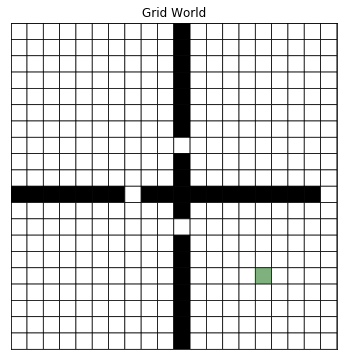

In [18]:
reload(expt)
reload(gw)
reload(ac)
rows, columns = 20,20
env_type = 'room'
penalty = -0.01 

NUM_TRIALS = 50000
NUM_EVENTS = 250


reward_location = (15,15)
env = gw.GridWorld(rows=rows,cols=columns,env_type=env_type,
                       rewards = {reward_location:1},
                       step_penalization=penalty,
                       rho=0.0,
                   actionlist = ['Down', 'Up', 'Right', 'Left'],
                       rewarded_action=None, barheight=10)
    
fig = gw.plotWorld(env, scale=0.3, four_actions=True)
print(env.doors)

In [16]:
training = {
    'load_model':  False,
    'load_dir':    '',
    'freeze_w':    False,

    'input_dims':  env.observation.shape,
    'action_dims': len(env.action_list),
    'hidden_types':['conv','pool','conv', 'pool', 'linear','linear'],
    'hidden_dims': [None, None, None, None, 100, 200],
    'use_SR':      True,

    'rfsize':      5,

    'gamma':       0.98,
    'eta':         5e-4,

    'use_EC':      False,
    'EC':          {},
    'cachelim':    300
    }

testing_1 = training.copy()
testing_1.update({'load_model':True, 'freeze_w':True})

testing_2 = testing_1.copy()
testing_2.update({'use_EC':True})

testing_4 = testing_1.copy()
testing_4.update({'freeze_w':False})

testing_5 = testing_4.copy()
testing_5.update({'use_EC':True})

agent_params = [training, testing_1, testing_2, testing_2, testing_4, testing_5, testing_5]

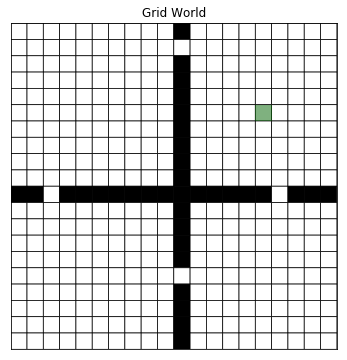

In [6]:
env.rewards = {(5,15):1}
env.buildRewardFunction()
fig = gw.plotWorld(env, scale=0.3, four_actions=True)

In [8]:
reload(expt)
for j in range(1):
    # get unique ID tag for this run
    save_id = uuid.uuid4()
    
    experiment_type = 0
    if experiment_type is not 0: 
        agent_params[experiment_type]['load_dir'] = f'../data/outputs/gridworld/weights/8ab3822b-28ad-4751-950f-20f0475507a9.pt',
    
    # generate agent from given parameters
    agent = ac.make_agent(agent_params[experiment_type])
    print(agent)
    
    # initialize data storage
    data = {'total_reward': [],
            'loss': [[],[],[]],
            'trial_length': [],
            'trials_run_to_date':0,
            'pol_tracking':[],
            'val_tracking':[],
            'ec_tracking': [],
            't': [],
            'mfcs':[]
           }
    
    mem_temp = 0.05 
    ex = expt.test_expt(agent, env, use_mem=agent_params['use_EC'], mem_temp=mem_temp)
    ex.run(10, NUM_EVENTS, data)
    
    
    if agent_params['use_EC']:
        mem = ex.episodic
    else:
        mem = None
    if agent.use_SR:
        arch = 'B'
    else: 
        arch = 'A'
    expt.log_experiments(save_id, experiment_type, 
                         env, agent, data, mem, 
                         save_flag = True, 
                         load=agent_params[experiment_type]['load_dir'], arch = arch)
    

ActorCritic(
  (hidden): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
    (2): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
    (4): Linear(in_features=432, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=200, bias=True)
  )
  (output): ModuleList(
    (0): Linear(in_features=200, out_features=4, bias=True)
    (1): Linear(in_features=200, out_features=1, bias=True)
  )
  (SR): Linear(in_features=200, out_features=200, bias=True)
)
0
0: -2.4999999999999907 (0.45011067390441895s)
1: -2.4999999999999907 (0.4526047706604004s)
2: -2.4999999999999907 (0.4578702449798584s)
3: -2.4999999999999907 (0.46292901039123535s)
4: -2.4999999999999907 (0.47197914123535156s)
5: -2.4999999999999907 (0.4722635746002197s)
6: 0.04999999999999938 (0.178261518

In [ ]:
print(save_id)

In [ ]:
smoothing = 50
plt.figure()
plt.plot(gp.running_mean(data['total_reward'],smoothing),'pink')
plt.title('Smoothed Reward Per Trial')
plt.show()
plt.close()

plt.figure()
#plt.plot(gp.running_mean(data['loss'][0],smoothing), 'darkgreen', label='$\pi$')
#plt.plot(gp.running_mean(data['loss'][1],smoothing), 'lightgreen', label='v')
plt.plot(gp.running_mean(data['loss'][2],smoothing), 'cyan', label='$\phi$')
plt.legend(loc=0)
plt.title('Smoothed Loss')
plt.show()
plt.close()

In [ ]:
reload(expt)

sample_observations = env.get_sample_obs()
pol_grid, val_grid = expt.get_snapshot(sample_observations, env,agent)
gp.plot_pref_pol(env, pol_grid, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)
gp.plot_polmap(env, pol_grid, threshold = 0.22)
gp.plot_valmap(env, val_grid, v_range = [0,1])

In [ ]:
print(data['trials_run_to_date'])

In [ ]:
save = f'../data/outputs/gridworld/weights/{save_id}.pt'
ac.torch.save(agent,save)

In [ ]:
reload(gp)
def ec_policies(maze, EC, trial_timestamp,**kwargs):
    envelope = kwargs.get('decay', 50)
    mem_temp = kwargs.get('mem_temp', 1)
    mpol_array = np.zeros(maze.grid.shape, dtype=[(x, 'f8') for x in maze.action_list])
    
    # cycle through readable states
    for key in EC.cache_list.keys():
        row, col = EC.cache_list[key][2]
        pol = EC.recall_mem(key, timestep = trial_timestamp, mem_temp = mem_temp, print_t=False)
        mpol_array[row,col] = tuple(pol)
        
    return mpol_array
        

abcd = ec_policies(env,ex.episodic, trial_timestamp = 0, mem_temp = 0.5)


In [ ]:
reload(gp)
gp.plot_pref_pol(env, abcd, threshold = 0.1, title='ec_pol_new_rwd',upperbound=2)

In [ ]:
state = (4,3)
env.set_state(env.twoD2oneD(state))
observation = torch.Tensor(np.expand_dims(env.get_observation(), axis=0))
policy_, value_, phi_, psi_ = agent(observation)

lin_act = tuple(np.round(phi_.data[0].numpy(),4))
key, sim = ex.episodic.cosine_sim(lin_act)

mem_state = ex.episodic.cache_list[key]

In [ ]:
print(mem_state)
print(ex.episodic.recall_mem(lin_act, timestep=0))
#print(abcd[state])
plt.bar(np.arange(4),ex.episodic.recall_mem(lin_act, timestep=0))
#MF_alone = data

In [ ]:
ex.mem_temp